In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as pyplot
import imutils

import tensorflow as tf
import keras
from keras import backend as K

Using TensorFlow backend.


In [2]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [3]:
model = keras.models.load_model('bill-segmentation-model-0.9546.h5', custom_objects={'mean_iou': mean_iou})

In [4]:
img = cv2.cvtColor(cv2.imread('images/1.jpg'), cv2.COLOR_BGR2RGB)

In [5]:
mask = model.predict(np.array([img / 255.0]))[0]
mask = mask > 0.5

In [6]:
def warp_document(mask, img):
    mask[0:3, :] = 0
    mask[:, 0:3] = 0
    mask[mask.shape[0]-3:mask.shape[0], :] = 0
    mask[:, mask.shape[1]-3:mask.shape[1]] = 0
    mask = np.uint8(mask * 255)

    ###

    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(mask,cv2.MORPH_OPEN,kernel, iterations = 2)
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.01*dist_transform.max(),255,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    ###

    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers+1
    markers[unknown==255] = 0

    ###

    markers = cv2.watershed(cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB),markers)
    markers = np.where(markers!=1, 1, 0)
    ret, m2 = cv2.threshold(markers.astype(np.uint8), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    m2[0:3, :] = 0
    m2[:, 0:3] = 0
    m2[m2.shape[0]-3:mask.shape[0], :] = 0
    m2[:, m2.shape[1]-3:mask.shape[1]] = 0

    ###

    contours = cv2.findContours(m2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE) 
    cnts = imutils.grab_contours(contours)
    cnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.05 * peri, True)

    ###

    right_top = left_bottom = right_bottom = left_top = approx[0][0]
    for p in approx:
        p = p[0]
        if p[0] + p[1] < left_top[0] + left_top[1]:
            left_top = p
        if p[0] + p[1] > right_bottom[0] + right_bottom[1]:
            right_bottom = p
        if p[0] - p[1] > left_bottom[0] - left_bottom[1]:
            left_bottom = p
        if -p[0] + p[1] > -right_top[0] + right_top[1]:
            right_top = p

    ###


    src_pts = np.array([left_top, right_top, right_bottom, left_bottom], dtype=np.float32)
    dst_pts = np.array([[0, 0],   [0, 1000],  [300, 1000], [300, 0]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    return cv2.warpPerspective(img, M, (300, 1000))

In [7]:
warped_bill = warp_document(mask, img)

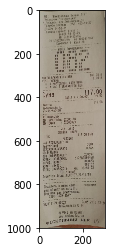

In [8]:
pyplot.figure()
pyplot.imshow(warped_bill)